In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import tqdm
import torch

#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
idnt = os.listdir("/kaggle/input/parkinsons-drawings/spiral/testing/healthy/")
print(len(idnt))

15


# **Importing SAM**

In [4]:
HOME = os.getcwd()
print("HOME:", HOME)
%cd {HOME}
# !pip install git+https://github.com/facebookresearch/segment-anything.git

!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

HOME: /kaggle/working
/kaggle/working
/kaggle/working/weights


# **I dont Know What This is!**

In [5]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

# **Creating Mask Generator Object for Mask Generation**

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [7]:
Spiral_Train_Path = Path("/kaggle/input/parkinsons-drawings/spiral/training")
Spiral_Test_Path = Path("/kaggle/input/parkinsons-drawings/spiral/testing")
Spiral_Train_PNG_Path = list(Spiral_Train_Path.glob(r"*/*.png")) 
# glob: It is a function or method that is typically used 
#to retrieve file paths or names that match a specific pattern.
Spiral_Test_PNG_Path = list(Spiral_Test_Path.glob(r"*/*.png"))
Spiral_Train_PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Spiral_Train_PNG_Path))
Spiral_Test_PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Spiral_Test_PNG_Path))

# map(lambda x: os.path.split(os.path.split(x)[0])[1], Spiral_Train_PNG_Path):
# This line applies the lambda function to each element in the Spiral_Train_PNG_Path list using the map() function.
Spiral_Train_PNG_Path_Series = pd.Series(Spiral_Train_PNG_Path,name="Image").astype(str)
Spiral_Train_PNG_Labels_Series = pd.Series(Spiral_Train_PNG_Labels,name="label")


# Main_Spiral_Train_Data = pd.concat([Spiral_Train_PNG_Path_Series,Spiral_Train_PNG_Labels_Series],axis=1)

# Main_Spiral_Test_Data = pd.concat([Spiral_Test_PNG_Path_Series,Spiral_Test_PNG_Labels_Series],axis=1)

In [8]:
Spiral_Train_PNG_Labels_Series.shape

(72,)

# **Train Data Importing**

In [9]:
# # #Creating feature and label data
img_size=256
train_dataset_df = pd.DataFrame(columns=['image_path','image','label'])
train_dataset_df['image_path']=Spiral_Train_PNG_Path_Series
train_dataset_df['image'] = (train_dataset_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((img_size,img_size)))))
train_dataset_df['label'] = [0 if i == "healthy" else 1 for i in Spiral_Train_PNG_Labels_Series]

# **Test Data Importing**

In [10]:

Spiral_Test_PNG_Path_Series = pd.Series(Spiral_Test_PNG_Path,name="Image").astype(str)
Spiral_Test_PNG_Labels_Series = pd.Series(Spiral_Test_PNG_Labels,name="label")

test_dataset_df = pd.DataFrame(columns=['image_path','image','label'])
test_dataset_df['image_path']= Spiral_Test_PNG_Path_Series
test_dataset_df['image'] = (test_dataset_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((img_size,img_size)))))
test_dataset_df['label'] = [0 if i == "healthy" else 1 for i in Spiral_Test_PNG_Labels_Series]

X_test_data = np.array(test_dataset_df['image'])
# X_data = np.delete(X_data, [1,4,12,14,21])
X_test_data = np.array([X_test_data[i] for i in range(X_test_data.shape[0])])
Y_test_data = np.array(test_dataset_df['label']).astype('float32')
# Y_test_data = np.delete(Y_data, [1,4,12,14,21])

In [11]:
Y_test_data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [12]:
X_data = np.array(train_dataset_df['image'])
X_data = np.delete(X_data, [1,4,12,14,21])
X_data = np.array([X_data[i] for i in range(X_data.shape[0])])
Y_data = np.array(train_dataset_df['label']).astype('float32')
Y_data = np.delete(Y_data, [1,4,12,14,21])

In [13]:
X = np.vstack((X_data,X_test_data))
Y= np.vstack((Y_data.reshape(67,1),Y_test_data.reshape(30,1)))

In [14]:
del X_data
del X_test_data

In [15]:
Y.shape

(97, 1)

In [16]:

# from collections import Counter
# # # clas = Counter(Y)
# # # print(clas)
# # plt.figure(figsize = (5,5))
# # sns.set_style("darkgrid")
# # sns.countplot(x=Y)
# # # Set custom labels for the x-axis ticks
# # plt.xticks(ticks=[0.0, 1.0], labels=['Healthy', 'Parkinson'])

# # plt.show()

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,stratify=Y)

In [18]:
# x_train = (x_train/255.0).astype('float32')
# x_test = (x_test/255.0).astype('float32')

In [19]:
x_train.shape

(67, 256, 256, 3)

# **Augmenting Images**

In [20]:
from tqdm import tqdm
def generate_masked_image(image):
    sam_mask = (mask_generator.generate(image))
    length = (len(sam_mask))
    sorted_mask = sorted(sam_mask, key=(lambda x: x['area']), reverse=True)
    x = np.array([sorted_mask[0]['segmentation']]).astype(np.uint8)
    # Copy the array three times using np.tile()
    x = np.tile(x, (3, 1, 1))

    x = np.transpose(x, (1, 2, 0))


    # Apply the binary mask to the image
    masked_image = np.multiply(image, x)
   
#     # Extract the masked object
    masked_object = np.copy(masked_image)
    return masked_image
    
    
    
x_train_masked = []
for i in tqdm(range(x_train.shape[0])):
#     temp = cv2.cvtColor(x_train[i,:,:,:],cv2.COLOR_RGB2BGR)
#     temp = cv2.cvtColor(x_train[i,:,:,:],cv2.COLOR_BGR2RGB)
    temp = generate_masked_image(x_train[i,:,:,:])
    x_train_masked.append(temp)
x_train_masked = np.array(x_train_masked)

x_test_masked = []
for i in tqdm(range(x_test.shape[0])):
#     temp = cv2.cvtColor(x_train[i,:,:,:],cv2.COLOR_RGB2BGR)
#     temp = cv2.cvtColor(x_train[i,:,:,:],cv2.COLOR_BGR2RGB)
    temp = generate_masked_image(x_test[i,:,:,:])
    x_test_masked.append(temp)
x_test_masked = np.array(x_test_masked)

100%|██████████| 30/30 [04:59<00:00,  9.97s/it]


In [21]:
# np.save('x_train_masked.npy',x_train_masked)
# np.save('y_train_masked.npy',y_train)
# np.save('x_test_masked.npy',x_test_masked)
# np.save('y_test_masked.npy',y_test)

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_train and y_train are already NumPy arrays
train_data_generator = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=True
)

num_augmented_samples = 70
desired_total_images = 1000

def data_generator():
    for x_img, y_label in zip(x_train_masked, y_train):
        x_img = np.expand_dims(x_img, axis=0)

        aug_iter = train_data_generator.flow(x_img, y=[y_label], batch_size=num_augmented_samples, shuffle=False)
        augmented_batch = next(aug_iter)

        yield augmented_batch[0], augmented_batch[1]

augmented_dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.float32))

# Shuffle and repeat the dataset as needed
augmented_dataset = augmented_dataset.shuffle(buffer_size=desired_total_images * 2).repeat()

# Limit the number of augmented images in the dataset
augmented_dataset = augmented_dataset.take(desired_total_images)

# Convert the dataset to numpy arrays
x_train_aug, y_train_aug = [], []
for x, y in augmented_dataset:
    x_train_aug.append(x.numpy())
    y_train_aug.append(y.numpy())

x_train_aug = (np.array(x_train_aug))
y_train_aug = np.array(y_train_aug)

print(x_train_aug.shape)
print(y_train_aug.shape)


(1000, 1, 256, 256, 3)
(1000, 1, 1)


In [23]:
x_train_aug = np.squeeze(x_train_aug,axis=1)
y_train_aug = np.squeeze(y_train_aug,axis=1)
# x_train_aug = np.array(x_train_aug)

In [24]:
# y_train_aug = np.array(y_train_aug)

In [25]:
# del x_train_aug

In [26]:
# del x_aug_train
# del y_aug_train

In [27]:
# del x
# del y

# **Model!!!**

In [28]:
# from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
# from keras import backend as K
# from keras.activations import sigmoid

# def spatial_attention(input_feature):
# 	kernel_size = 7
	
# 	if K.image_data_format() == "channels_first":
# 		channel = input_feature.shape[1]
# 		cbam_feature = Permute((2,3,1))(input_feature)
# 	else:
# 		channel = input_feature.shape[-1]
# 		cbam_feature = input_feature
	
# 	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
# 	assert avg_pool.shape[-1] == 1
# 	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
# 	assert max_pool.shape[-1] == 1
# 	concat = Concatenate(axis=3)([avg_pool, max_pool])
# 	assert concat.shape[-1] == 2
# 	cbam_feature = Conv2D(filters = 1,
# 					kernel_size=kernel_size,
# 					strides=1,
# 					padding='same',
# 					activation='sigmoid',
# 					kernel_initializer='he_normal',
# 					use_bias=False)(concat)	
# 	assert cbam_feature.shape[-1] == 1
	
# 	if K.image_data_format() == "channels_first":
# 		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
# 	return multiply([input_feature, cbam_feature])

# **Model Fro ChatGPT**

# **Applying SAM**

In [29]:
# sample_mask = (mask_generator.generate(x_train[2,:,:,:]))
# sample_len = len(sample_mask)

In [30]:
# sorted_sample_mask = sorted(sample_mask, key=(lambda x: x['area']), reverse=True)

In [31]:
from tqdm import tqdm

In [32]:
# np.save('masked_image_train.npy', x_train_masked)

In [33]:
# x_test_masked = []
# for i in tqdm(range(x_test.shape[0])):
# #     temp = cv2.cvtColor(x_train[i,:,:,:],cv2.COLOR_RGB2BGR)
# #     temp = cv2.cvtColor(x_train[i,:,:,:],cv2.COLOR_BGR2RGB)
#     temp = generate_masked_image(x_test[i,:,:,:])
#     x_test_masked.append(temp)
# x_test_masked = np.array(x_test_masked)
# np.save('masked_image_test.npy', x_test_masked)

# **Previous Model**

In [34]:
# from tensorflow.keras.models import Sequential, Model,load_model
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import *
# # tf_input=tf.keras.Input(shape=(img_size,img_size,3))

# tf_input=tf.keras.Input(shape=(img_size,img_size,3))

# #1st Branch
# input_1 = spatial_attention(tf_input)
# input_1 = Concatenate()([tf_input, input_1])
# input_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size =(3,3),activation = 'relu',padding='same')(input_1)
# input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)
# input_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size =(3,3),activation = 'relu',padding='same')(input_1)
# input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)
# input_1 = tf.keras.layers.Conv2D(filters = 128, kernel_size =(3,3),activation = 'relu',padding='same')(input_1)
# input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)
# input_1 = tf.keras.layers.MaxPooling2D(4,4)(input_1)

# # input_1 = tf.keras.layers.Reshape((2,2,2048))(input_1)
# #RESNET50 Branch
# res_model=tf.keras.applications.VGG16(include_top=False,input_tensor=tf_input,weights='imagenet')
# output = res_model.get_layer(index = -1).output

# output = tf.keras.layers.BatchNormalization()(output)

# output_1 = Concatenate()([output, input_1])
# output = tf.keras.layers.Dense(512, activation="relu",kernel_regularizer='l2')(output_1)
# output = tf.keras.layers.Dense(256, activation="relu",kernel_regularizer='l2')(output)
# output = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer='l2')(output)
# output = tf.keras.layers.Dense(64, activation="relu",kernel_regularizer='l2')(output)
# output = tf.keras.layers.Dense(32, activation="relu",kernel_regularizer='l2')(output)
# output = tf.keras.layers.Dense(16, activation="relu",kernel_regularizer='l2')(output)
# output = tf.keras.layers.Dropout(0.2)(output)
# output = tf.keras.layers.Flatten()(output)
# output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
# model = Model(tf_input, output)




# **Experimental Model**

Model-1

In [35]:
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
# tf_input=tf.keras.Input(shape=(img_size,img_size,3))
regularizer = tf.keras.regularizers.l2(0.001)
tf_input=tf.keras.Input(shape=(img_size,img_size,3))

#RESNET50 Branch
res_model=tf.keras.applications.DenseNet201(include_top=False,input_tensor=tf_input,weights='imagenet')
for layer in res_model.layers:
    layer.trainable = False
output = res_model.get_layer(index = -1).output


input_1 = tf.keras.layers.BatchNormalization()(output)
input_1 = tf.keras.layers.Conv2D(32, kernel_size =(3,3),activation = 'relu',padding='same',kernel_initializer='glorot_uniform', kernel_regularizer=regularizer)(input_1)
input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)
input_1 = tf.keras.layers.Conv2D(64, kernel_size =(3,3),activation = 'relu',padding='same',kernel_initializer='glorot_uniform', kernel_regularizer=regularizer)(input_1)
input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)
input_1 = tf.keras.layers.Conv2D(128, kernel_size =(3,3),activation = 'relu',padding='same',kernel_initializer='glorot_uniform', kernel_regularizer=regularizer)(input_1)
input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)
input_1 = tf.keras.layers.Conv2D(256, kernel_size =(3,3),activation = 'relu',padding='same',kernel_initializer='glorot_uniform', kernel_regularizer=regularizer)(input_1)
# input_1 = tf.keras.layers.MaxPooling2D(2,2)(input_1)


output_1 = tf.keras.layers.Flatten()(input_1)

output = tf.keras.layers.Dense(512, activation="relu",kernel_regularizer='l2')(output_1)
output = tf.keras.layers.Dense(256, activation="relu",kernel_regularizer='l2')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer='l2')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(64, activation="relu",kernel_regularizer='l2')(output)
output = tf.keras.layers.Dense(32, activation="relu",kernel_regularizer='l2')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(16, activation="relu",kernel_regularizer='l2')(output)
output = tf.keras.layers.Dropout(0.2)(output)

output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
model = Model(tf_input, output)

74836368/74836368 [==============================] - 4s 0us/step


In [36]:
# X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# # Data Preprocessing
# # Normalize pixel values to the range [0, 1]
# X_train =X_train.astype('float32') / 255.0
# # X_val = X_val.astype('float32') / 255.0
# X_test = X_test.astype('float32') / 255.0


In [37]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Constants
# image_size = (256, 256)
# batch_size = 8
# num_classes = 1
# num_epochs_finetuning = 300
# learning_rate_finetuning = 1e-2

# # Load your handwriting dataset and split into training, validation, and test sets
# # X_train, y_train, X_val, y_val, X_test, y_test = ...

# # Create VGG16 model with pretrained weights (excluding top classification layers)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# # Freeze the pre-trained layers so they are not updated during fine-tuning
# for layer in base_model.layers:
#     layer.trainable = False

# # Add new layers on top of the pre-trained VGG16 model
# x = base_model.output
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(num_classes, activation='sigmoid')(x)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=learning_rate_finetuning),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=(0.8, 1.2)
# )
# datagen.fit(X_train)

# # Train the model with fine-tuning
# model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
#           steps_per_epoch=len(X_train) // batch_size,
#           epochs=num_epochs_finetuning,
#           validation_data=(X_val, y_val))

# # Evaluate on the test set
# loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
# print(f"Test accuracy: {accuracy}")

In [38]:
# del X
# del Y

In [39]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [40]:
model.summary()
# keras.utils.vis_utils.plot_model(model,to_file='model_Net.png',show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [41]:
from keras.callbacks import *
# filepath='./val_aux_output_accuracy:{val_accuracy:.3f}-epochs:{epoch:03d}.hdf5'
filepath = './Best_model_parkinson.hdf5'
#earlyStopping = EarlyStopping(monitor='val_aux_output_loss', patience=10, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1,save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, mode='max',patience=2,verbose=1,min_lr=0.001)
#callbacks_list = [checkpoint]
callbacks_list = [checkpoint, reduce_lr]

In [42]:
x_train_aug = x_train_aug/255.0
x_test_masked = x_test_masked/255.0

In [43]:
# Train the model.
history=model.fit(x_train_aug,y_train_aug, batch_size = 32 ,epochs =100 ,validation_split=0.3,callbacks = callbacks_list)

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 8.3526 - accuracy: 0.6100
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to ./Best_model_parkinson.hdf5
22/22 [==============================] - 35s 654ms/step - loss: 8.3526 - accuracy: 0.6100 - val_loss: 5.8528 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 4.4254 - accuracy: 0.8971
Epoch 2: val_accuracy did not improve from 0.90000
22/22 [==============================] - 4s 175ms/step - loss: 4.4254 - accuracy: 0.8971 - val_loss: 3.5367 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 2.3984 - accuracy: 0.9557
Epoch 3: val_accuracy did not improve from 0.90000
22/22 [==============================] - 4s 171ms/step - loss: 2.3984 - accuracy: 0.9557 - val_loss: 1.9013 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 1.4262 - accur

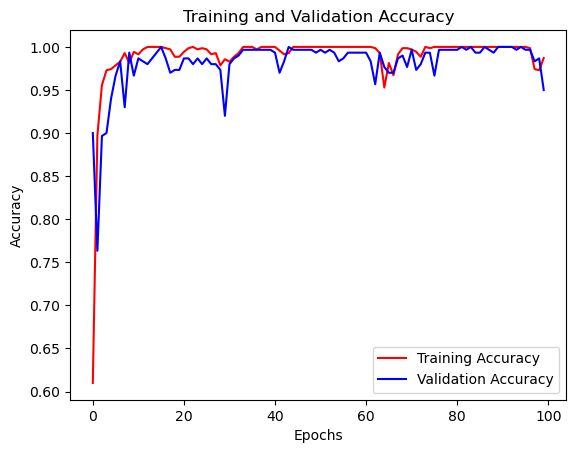

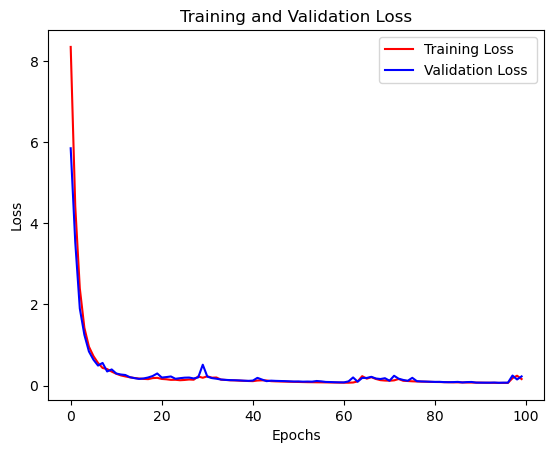

In [44]:
import matplotlib.pyplot as plt
main_acc = history.history['accuracy']

main_val_acc = history.history['val_accuracy']


main_loss = history.history['loss']

main_val_loss = history.history['val_loss']


epochs = (range(int(len(main_acc))))

plt.plot(epochs, main_acc, 'r', label='Training Accuracy')


plt.plot(epochs, main_val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.legend()
plt.grid(False)
plt.savefig('Net_aaccuracy_new_final.jpg', bbox_inches='tight')

plt.figure()

plt.plot(epochs, main_loss, 'r', label='Training Loss ')

plt.plot(epochs, main_val_loss, 'b', label='Validation Loss ')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')



plt.legend()
plt.grid(False)
plt.savefig('Net_loss_new_final.jpg', bbox_inches='tight')
plt.show()

In [45]:
# !pip install pycm
# from pycm import *
# from pycm import ConfusionMatrix as CM

In [91]:
# # from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# # import numpy as np

# y_pred = np.round(model.predict(X_test_data))
# y_t = (Y_test_data.reshape(-1, 1))



# # Convert y_t and y_pred to 1D arrays
# y_t = np.squeeze(y_t)
# y_pred = np.squeeze(y_pred)

# # Create ConfusionMatrix object
# cm = CM(actual_vector=y_t, predict_vector=y_pred)

# # Print the confusion matrix
# print(cm)
# cm.relabel(mapping={0.0:"Healthy",1:"Parkinson"})
# # Plot the confusion matrix
# cm.plot(cmap="Blues", plot_lib="matplotlib")

# # Show the plot
# plt.show()

model_path = "/kaggle/working/weights/Best_model_parkinson.hdf5"
Model = keras.models.load_model(model_path)
Model.evaluate(x_test_masked,y_test)






1/1 [==============================] - 3s 3s/step - loss: 0.3468 - accuracy: 0.9667


[0.34675121307373047, 0.9666666388511658]

In [47]:
import pickle
with open('./trainHistory_parkinson', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# For Loading Purpose
# with open('/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)

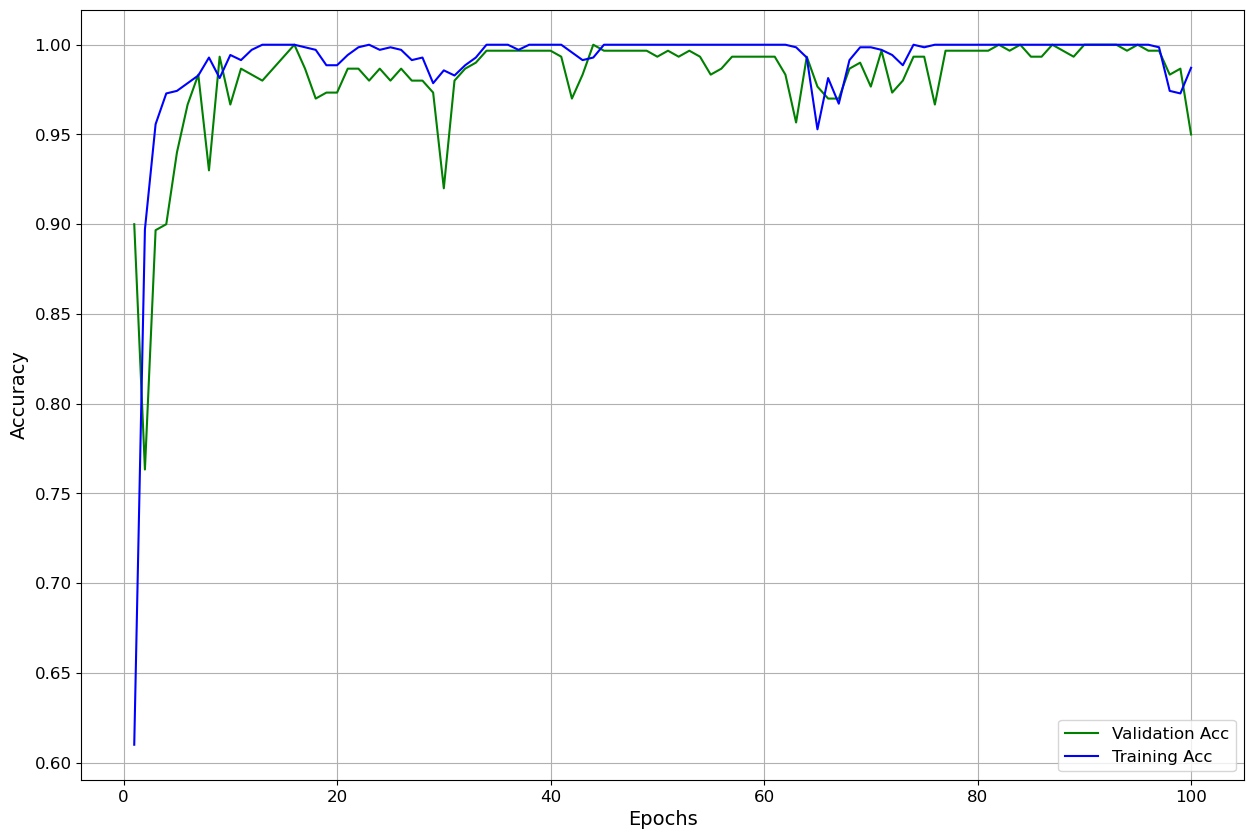

In [92]:
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

# For Loading Purpose
with open('/kaggle/working/weights/trainHistory_parkinson', "rb") as file_pi:
    history = pickle.load(file_pi)
viz_start = 0
epoch = 100
plt.figure(figsize=(15,10))
training_accuracy=history['accuracy'][viz_start:epoch]
epochs=range(viz_start+1,epoch+1)
vali_ac=history['val_accuracy'][viz_start:epoch]
plt.plot(epochs,vali_ac,'g',label='Validation Acc')
plt.plot(epochs,training_accuracy,'b',label='Training Acc')
plt.xlabel('Epochs',fontdict=font)  # X-axis legend
plt.ylabel('Accuracy',fontdict=font)  # Y-axis legend
plt.grid(True)  # Enable gridlines
plt.legend(fontsize=12)  # Legend font size
plt.xticks(fontsize=12)  # X-axis tick font size
plt.yticks(fontsize=12)  # Y-axis tick font size
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)  # Adjust margins
plt.savefig('Accuracy.svg',dpi=600)
plt.show()

In [93]:
Model.evaluate(x_test_masked,y_test)

1/1 [==============================] - 0s 152ms/step - loss: 0.3468 - accuracy: 0.9667


[0.34675121307373047, 0.9666666388511658]

In [85]:
y_pred

array([1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [86]:
y_t

array([1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [89]:
!pip install pycm
from pycm import *
y_pred = np.squeeze(np.round(Model.predict(x_test_masked)))

y_t = np.squeeze(y_test)
CM = ConfusionMatrix(actual_vector=y_t, predict_vector=y_pred)

print(CM)

1/1 [==============================] - 0s 72ms/step
Predict   0.0       1.0       
Actual
0.0       14        0         

1.0       1         15        





Overall Statistics : 

95% CI                                                            (0.90243,1.0309)
ACC Macro                                                         0.96667
ARI                                                               0.86653
AUNP                                                              0.96875
AUNU                                                              0.96875
Bangdiwala B                                                      0.93556
Bennett S                                                         0.93333
CBA                                                               0.93542
CSI                                                               0.93542
Chi-Squared                                                       26.25
Chi-Squared DF                                                    1
Cond

In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_t and y_pred are your ground truth and predicted labels respectively
precision = precision_score(y_t, y_pred)
recall = recall_score(y_t, y_pred)
f1 = f1_score(y_t, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 1.0
Recall: 0.9375
F1-Score: 0.967741935483871


In [83]:
from sklearn.metrics import classification_report

# Assuming y_t and y_pred are your ground truth and predicted labels respectively
# class_names = ["Healthy", "Parkinson"]  # Replace with your class labels

report = classification_report(y_t, y_pred, digits=4)

print(report)

              precision    recall  f1-score   support

         0.0     0.9333    1.0000    0.9655        14
         1.0     1.0000    0.9375    0.9677        16

    accuracy                         0.9667        30
   macro avg     0.9667    0.9688    0.9666        30
weighted avg     0.9689    0.9667    0.9667        30



In [90]:
import numpy as np

y_true = y_t
def calculate_classwise_accuracy(y_true, y_pred, class_value):
    TP_C = np.sum((y_true == class_value) & (y_pred == class_value))
    print(TP_C)
    FN_C = np.sum((y_true == class_value) & (y_pred != class_value))
    print(FN_C)
    classwise_accuracy = TP_C / (TP_C + FN_C)
    return classwise_accuracy

class_0_accuracy = calculate_classwise_accuracy(y_true, y_pred, class_value=0)
class_1_accuracy = calculate_classwise_accuracy(y_true, y_pred, class_value=1)

print("Class 0 Accuracy:", class_0_accuracy)
print("Class 1 Accuracy:", class_1_accuracy)


14
0
15
1
Class 0 Accuracy: 1.0
Class 1 Accuracy: 0.9375
